# CBCT calibration development notebook

## Load needed modules

In [149]:
import CBCT_Calibration as cbct
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.measure import EllipseModel
import cv2

import sys
sys.path.append('/Users/kaestner/git/scripts/python/')
import amglib.readers as io

import importlib

## Load the data


In [256]:

datapath = '/Users/Shared/data/P20240130_1/02_rawdata/00_setup/cbct-cal/'

dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=5,averageStack=True,average='mean');
proj=io.read_images(datapath+'ct_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

## Data preparation
- Create an instance of the CBCT_Calibration class
- Set the dark current and open beam images
- Set the calibration images
- Normalize
- Threshold

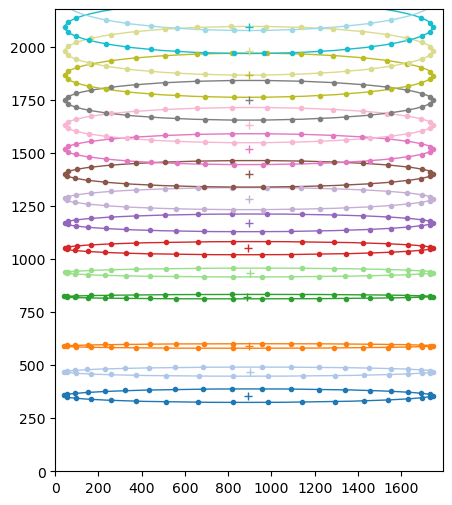

In [326]:
importlib.reload(cbct)  
cal = cbct.CBCTCalibration()
cal.set_projections(proj=proj,ob=ob,dc=dc,verticalflip=True,show=False)
cal.threshold_projections(threshold=0.15, show=False,clearborder=True)
cal.find_beads(show=False)
cal.find_trajectories(show=False)
cal.fit_ellipses(show=True,prune=True)
e=cal.ellipses

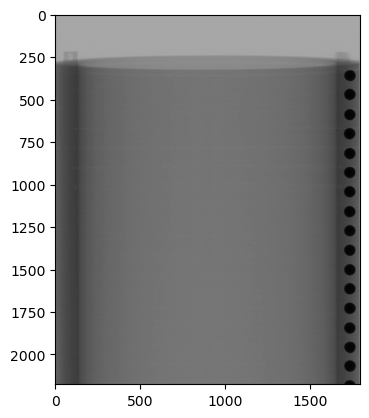

In [327]:
plt.imshow(cal.projections[0],cmap='gray')

{'COR': {'slope': 0.0005888423944748675,
  'center': 894.2372110484584,
  'tilt': 0.033738180102381075},
 'SDD': 1317.1596244210753,
 'SOD': 278.38090727610404,
 'pp': {'y': 707.3679088836715, 'x': array([   0.18000709, -127.52225361])},
 'MAG': 4.730939318847657}

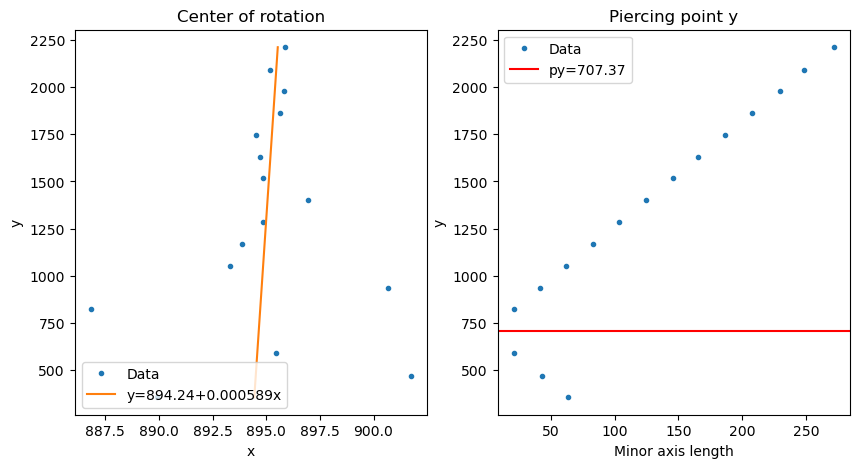

In [324]:
importlib.reload(cbct)

cal = cbct.CBCTCalibration()
cal.ellipses=e
cal.compute_calibration(avgtype='median', remove_outliers=True,show=True)
#cal._compute_piercing_point2(degree=3, show=True)

cal.calibration
